In [1]:
using LinearAlgebra, Plots, Random, Distributions

In [2]:
# structural_params = [alpha, beta, lambda, benefits, beta_hat]
Params = Vector{Float64}([0.0009, 0.995, 0.009, 0.1, 0.9941045])
# grid_sizes = [hc_grid_size, search_grid_size, wage_grid_size]
Sizes = Vector{Int64}([201, 41, 41])
# grid_bounds = [hc_min, hc_max, search_min, search_max, wage_min, wage_max]
Bounds = Vector{Float64}([1.0, 2.0, 0.0, 1.0, 0.0, 1.0])
# human_capital_losses = [unemployment_loss, job_loss]
Losses = Vector{Int64}([10, 30])
# draw_matrices = [number_of_workers, number_of_periods, seed]
Draw = Vector{Int64}([10000, 201, 4])

3-element Vector{Int64}:
 10000
   201
     4

In [3]:
function search_grid(S,B)

    grid = range(B[3], stop=B[4], length=S[2])

    return grid

end

search_grid (generic function with 1 method)

In [4]:
function wage_grid(S,B)

    grid = range(B[5], stop=B[6], length=S[3])

    lower, upper = 0, 1

    dist = Normal(0.5, sqrt(0.1))

    truncated_dist = Truncated(dist, lower, upper)
    # Compute the probability density function at each point in the wage grid
    pdf_values = [pdf(truncated_dist, point) for point in grid]
    # Normalise the probabilities so they sum to 1
    probs = pdf_values / sum(pdf_values)

    return grid, probs

end

wage_grid (generic function with 1 method)

In [6]:
w_grid, w_probs = wage_grid(Sizes, Bounds)

(0.0:0.025:1.0, [0.010096205463672238, 0.011404803845416155, 0.012802745710944611, 0.014282494929326978, 0.015834002055889584, 0.01744467870008861, 0.01909945224920802, 0.020780907501498747, 0.02246951848187184, 0.024143969930210292  …  0.024143969930210292, 0.02246951848187183, 0.02078090750149875, 0.01909945224920802, 0.01744467870008861, 0.015834002055889584, 0.014282494929326974, 0.012802745710944618, 0.011404803845416155, 0.010096205463672238])

In [5]:
function human_capital_grid(S,B)

    grid = range(B[1], stop=B[2], length=S[1])

    return grid

end

human_capital_grid (generic function with 1 method)

In [6]:
function initial_value_functions(S)

    U = zeros(S[1], 1)

    W = zeros(S[1], S[2])

    return U, W

end

initial_value_functions (generic function with 1 method)

In [7]:
function cost_of_search(S,B)

    grid = search_grid(S,B)

    cost = (1/2) .* grid 

    return cost

end

cost_of_search (generic function with 1 method)

In [8]:
function contact_probability(S,B)

    grid = search_grid(S,B)

    contact_probs = grid .^ (0.3)

    return contact_probs

end

contact_probability (generic function with 1 method)

In [9]:
function Bellman(B, L, S, P, tolerance, max_iterations, tau)

    U_0, W_0 = initial_value_functions(S)

    U_1, W_1 = similar(U_0), similar(W_0)

    search_intensity = similar(U_0)

    store_U_values = zeros(S[2], S[3])

    hc_grid = human_capital_grid(S,B)

    s_grid = search_grid(S,B)

    w_grid, w_probs = wage_grid(S,B)

    cost = cost_of_search(S,B)

    contact_probs = contact_probability(S,B)

    reservation_wages = Float64[]

    error = tolerance + 1

    iter = 1

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid)

    b = P[4]

    unemployment_loss, job_loss = L[1], L[2]

    hc_tomorrow_unemp = 0

    #display("----- Iterating... -----")

    while error > tolerance

        for i in 1:S[1]

            if i <= 11

                hc_tomorrow_unemp = min_hc

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            else

                hc_tomorrow_unemp = hc_grid[i-10]

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            end

            for i in 1:S[1]

                if i <= 31

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[1,1]))

                    end

                else 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i,j]) + ((P[5] * (1 - P[4]) * U_1[i-30,1]))

                    end

                end

            end

        end

        error_unemp = maximum(abs.(U_1 - U_0))

        error_emp = maximum(abs.(W_1 - W_0))

        error = max(error_unemp, error_emp)

        if iter % 25 == 0

            println("Iteration: ", iter, " Error: ", error)

        end

        U_0, W_0 = copy(U_1), copy(W_1)

        iter += 1
    
    end

    for i in 1:S[1]

        index = findfirst(x -> x >= U_1[i,1], W_1[i,:])
        
        if index !== nothing

            push!(reservation_wages, w_grid[index])

        else

            push!(reservation_wages, w_grid[S[3]])  # Append the max value of the wage grid

        end

    end

    #display("---- Bellman has been solved... ----")

    #display(plot(U_1, title = "Plot of U_1", xlabel = "Human Capital Index", ylabel = "Value", legend = false))

    #plot(W_1[:,1], title = "Plot of W_1 columns", xlabel = "Human Capital Index", ylabel = "Value", legend = false)

    #for j in 2:size(W_1, 2)
    #    plot!(W_1[:,j])
    #end

    #display(plot!())

    #display(plot(search_intensity, title = "Plot of Search Costs", xlabel = "Human Capital Index", ylabel = "Search Costs", legend = false))

    #display(plot(reservation_wages, title = "Plot of Reservation Wages", xlabel = "Human Capital Index", ylabel = "Wage", legend = false))

    return W_1, U_1, search_intensity, reservation_wages

end

Bellman (generic function with 1 method)

In [21]:
@time begin
W_out, U_out, match_probs, res_wages = Bellman(Bounds, Losses, Sizes, Params, 1e-3, 1000, 0.5)
end

"----- Iterating... -----"

"---- Bellman has been solved... ----"

([16.14480672325679 16.158694180627634 … 16.686417560719775 16.700305018090624; 16.14480672325679 16.15876357961189 … 16.689124121105692 16.703080977460793; … ; 16.541590294604056 16.569280489321507 … 17.621507888584578 17.64919808330203; 16.546093203874435 16.573852797576137 … 17.628717358240873 17.656476951942576], [16.251301164106412; 16.251301164106412; … ; 16.801639710190127; 16.80698970761044;;], [0.025; 0.025; … ; 0.05; 0.05;;], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [10]:
function draw_matrices(D, S, B, L, P)
    # Create the human capital grid
    hc_grid = human_capital_grid(S, B)
    # Unpack the draw parameters
    number_of_workers, number_of_periods, seed = D[1], D[2], D[3]
    # Set the seed
    Random.seed!(seed)
    # Draw human capital of initial workers
    #initial_human_capital = rand(hc_grid, number_of_workers)
    # Draw human capital of newborn workers for each period in which they could be born
    human_capital_draws = [rand(hc_grid) for _ in 1:number_of_workers, _ in 1:(number_of_periods)]
    # Draw job loss probabilities for each worker and each period in which they could lose their job
    job_loss_probabilities = rand(number_of_workers, number_of_periods - 1)
    # Create the wage grid and the associated probabilities
    w_grid, w_probs = wage_grid(S,B)
    # Draw wage offers for each worker and each period
    wage_offers = [rand(w_grid) for _ in 1:number_of_workers, _ in 1:number_of_periods]
    # Draw death probabilities for each worker and each period in which they could die
    death_probabilities = rand(number_of_workers, number_of_periods - 1)
    # Draw match probabilities for each worker and each period in which they could be matched
    match_probabilities = rand(number_of_workers, number_of_periods - 1)

    ###

    #job_losses = any(job_loss_probabilities .< 0.09)

    #deaths = any(death_probabilities .< 0.0009)  

    ###

    return human_capital_draws, job_loss_probabilities, wage_offers, death_probabilities, match_probabilities

    #return job_losses, deaths ### there are losses and deaths in the economy ###

end 

draw_matrices (generic function with 1 method)

In [90]:
hc_draws, sacked_prob, w_offers, death_prob, match_probs = draw_matrices(Draw, Sizes, Bounds, Losses, Params)
#losses, deaths = draw_matrices(Draw, Sizes, Bounds, Losses, Params)

([1.3, 1.085, 1.16, 1.185, 1.46, 1.535, 1.785, 1.61, 1.695, 1.575  …  1.94, 1.755, 1.58, 1.345, 1.77, 1.24, 1.685, 1.59, 1.78, 1.7], [1.07 1.605 … 1.975 1.36; 1.735 1.11 … 1.33 1.265; … ; 1.935 1.585 … 1.535 1.735; 1.775 1.21 … 1.285 1.475], [0.9296817863322564 0.19403450388939392 … 0.5074646585576883 0.2872148451363469; 0.32810335132628154 0.48712668536593007 … 0.7642916658291372 0.6954780515341381; … ; 0.22217962409870684 0.9025248051196569 … 0.7637886287749661 0.9360351964252113; 0.6601784418126794 0.176154985106191 … 0.5738517508329355 0.49975992274454106], [0.775 0.4 … 0.0 0.9; 0.25 0.95 … 0.45 0.375; … ; 0.1 0.3 … 0.15 0.0; 0.1 0.85 … 0.05 0.4], [0.7410603739201328 0.221721386504108 … 0.9480638803479762 0.7799618771382438; 0.7530996729137789 0.7946086393750906 … 0.5647845041425161 0.9036596897492285; … ; 0.7114262846374387 0.08069564958978948 … 0.8957327083880275 0.8379014791278039; 0.2626500476440137 0.9468086808026296 … 0.4238450685954972 0.26231282679340373], [0.11765542764681

In [11]:
function initialise_matrices( D, S, B, L, P)
    # Unpack the draw parameters
    number_of_workers, number_of_periods = D[1], D[2]
    # Initialise the employment matrix
    employment_matrix = zeros(Int64, number_of_workers, number_of_periods)
    # Initialise the wage matrix
    wage_matrix = zeros(Float64, number_of_workers, number_of_periods)
    # Initialise the human capital matrix
    human_capital_matrix = zeros(Float64, number_of_workers, number_of_periods)
    
    return employment_matrix, wage_matrix, human_capital_matrix
    
end

initialise_matrices (generic function with 1 method)

In [12]:
function sim( D, S, B, L, P, tol, max_iterations, tau)

    W_out, U_out, search_int, res_wages = Bellman(B, L, S, P, tol, max_iterations, tau) # solve for the value and policy functions

    hc_draws, sacked_prob, w_offers, death_prob, match_prob = draw_matrices(D, S, B, L, P) # draw the random matrices

    employment_sim, wage_sim, hc_sim = initialise_matrices(D, S, B, L, P) # initialise the matrices where will store the simulation results

    hc_grid = human_capital_grid(S,B) # human capital grid

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid) # human capital bounds

    unemployment_loss, job_loss = L[1], L[2] # human capital losses

    N, T = D[1], (D[2]-1) # N = number of workers, T = number of periods

    for n in 1:N

        for t in 1:T 

            if death_prob[n,t] > P[1] # survive

                if employment_sim[n,t] == 1 # employed

                    if t == 1

                        hc_index = findfirst(isequal(hc_draws[n,1]), hc_grid) # find the index of current human capital in the initial grid (first period only)

                    else

                        hc_index = findfirst(isequal(hc_sim[n,t]), hc_grid) # find the index of current human capital in the grid

                    end

                    if sacked_prob[n,t] <= P[3] # job loss

                        employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                        wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                        if hc_index <= 31
                                    
                            hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                        else

                            hc_sim[n,t+1] = hc_grid[hc_index - job_loss] ## unemployment human capital loss

                        end

                    else # keep job

                        employment_sim[n,t+1] = 1 ## they'll be employed tomorrow

                        wage_sim[n,t+1] = wage_sim[n,t] ## the wage they'll be earning tomorrow

                        if hc_index <= 200
                                    
                            hc_sim[n,t+1] = hc_grid[hc_index+1] ## accumulate human capital until they reach the maximum

                        else

                            hc_sim[n,t+1] = max_hc ## human capital is bounded above

                        end

                    end

                else # unemployed

                    if t == 1

                        hc_index = findfirst(isequal(hc_draws[n,1]), hc_grid) # find the index of current human capital in the initial grid (first period only)

                    else

                        hc_index = findfirst(isequal(hc_sim[n,t]), hc_grid) # find the index of current human capital in the grid

                    end

                    if match_prob[n,t] < search_int[hc_index] # match

                        if w_offers[n,t] > res_wages[hc_index] ## if they'd accept the wage offer

                            wage_sim[n,t+1] = w_offers[n,t] ## they'll be earning the wage tomorrow

                            employment_sim[n,t+1] = 1 ## they'll be employed tomorrow

                            if hc_index <= 21
                                    
                                hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                            else

                                hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                            end

                        else ## if they wouldn't accept the wage offer

                            wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                            employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                            if hc_index <= 11
                                    
                                hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                            else

                                hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                            end

                        end

                    else # stay unemployed

                        wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                        employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                        if hc_index <= 11
                                    
                            hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                        else

                            hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                        end

                    end

                end

            else # die

                hc_sim[n,t+1] = hc_draws[n,t] ## replaced by a newborn

                employment_sim[n,t+1] = 0 ## who will start unemployed

                wage_sim[n,t+1] = 0 ## and won't be earning anything tomorrow (fill in benefits later)

            end

        end
    
    end

    return employment_sim, wage_sim, hc_sim

end

sim (generic function with 1 method)

In [52]:
employment_sim, wage_sim, hc_sim = sim(Draw, Sizes, Bounds, Losses, Params, 1e-3, 1000, 0.5)

"----- Iterating... -----"

"---- Bellman has been solved... ----"

([0 0 … 1 1; 0 0 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1], [0.0 0.0 … 0.575 0.575; 0.0 0.0 … 0.325 0.325; … ; 0.0 0.0 … 0.975 0.975; 0.0 0.0 … 0.725 0.725], [0.0 1.25 … 1.97 1.975; 0.0 1.035 … 1.51 1.515; … ; 0.0 1.73 … 1.28 1.285; 0.0 1.65 … 1.275 1.28])

In [13]:
function find_tax_rate(D, S, B, L, P, Bellman_tolerance, maximum_iterations)

    # Params
    number_of_workers = D[1]
    
    # Initialise the tax rate bounds
    lower_bound = 0.0
    upper_bound = 1.0

    # Define the number of columns to extract
    num_columns = 100

    government_spending = ones(D[1], 100)
    # Initialise the unemployment rate
    unemployment_rate = 5.0

    while abs(sum(government_spending)) > 0.01
        # update the guess
        guess_tau = (lower_bound + upper_bound) / 2
        # simulate the economy with the new guess
        employment_sim, wage_sim, hc_sim = sim( D, S, B, L, P, Bellman_tolerance, maximum_iterations, guess_tau) # Simulate the economy

        # Create new matrices with the last 100 columns
        employment_sim_last_100 = employment_sim[:, end-num_columns+1:end]

        wage_sim_last_100 = wage_sim[:, end-num_columns+1:end]

        hc_sim_last_100 = hc_sim[:, end-num_columns+1:end]

        # Fill in wage_sim with (1-guess_tau)*b where employment_sim is zero
        wage_sim_last_100[employment_sim_last_100 .== 0] .= (1 - guess_tau) * P[3]
        # Fill in wage_sim with (1-guess_tau)*wage_sim*hc_sim where employment_sim is one
        wage_sim_last_100[employment_sim_last_100 .== 1] .= ((1 - guess_tau) .* wage_sim_last_100[employment_sim_last_100 .== 1]) .* hc_sim_last_100[employment_sim_last_100 .== 1]
        # Fill in government_spending with -(1-guess_tau)*b where employment_sim is zero
        government_spending[employment_sim_last_100 .== 0] .= -(1-guess_tau) * P[3]
        # Fill in government_spending with (guess_tau*wage_sim*hc_sim) where employment_sim is one
        government_spending[employment_sim_last_100 .== 1] .= ((guess_tau .* wage_sim_last_100[employment_sim_last_100 .== 1]) .* hc_sim_last_100[employment_sim_last_100 .== 1])
        #Find the unemployment rate
        unemployment_rate = sum(employment_sim_last_100 .== 0) / (number_of_workers) # get rid of num_columns so that it is a percentage      

        # Check if the market clears
        if sum(government_spending) < 0

            lower_bound = guess_tau

            upper_bound = upper_bound

        else

            lower_bound = lower_bound

            upper_bound = guess_tau

        end

    end
    # once convergence is reached, return the tax rate and the unemployment rate
    tax_rate = (lower_bound + upper_bound) / 2

    return tax_rate*100, unemployment_rate
end

find_tax_rate (generic function with 1 method)

In [14]:
@time begin
tax_rate = find_tax_rate(Draw, Sizes, Bounds, Losses, Params, 1e-3, 1000)
end

Iteration: 25 Error: 0.10910697785816836
Iteration: 50 Error: 0.0886352178392471
Iteration: 75 Error: 0.07238027064038377
Iteration: 100 Error: 0.05915665462775088
Iteration: 125 Error: 0.048370540358066094
Iteration: 150 Error: 0.03957447241278622
Iteration: 175 Error: 0.03237886570434334
Iteration: 200 Error: 0.026518293908809554
Iteration: 225 Error: 0.02171854583593813
Iteration: 250 Error: 0.017786864612473252
Iteration: 275 Error: 0.014566744043627011
Iteration: 300 Error: 0.011939011847653447
Iteration: 325 Error: 0.009788881231608926
Iteration: 350 Error: 0.008025973756396354
Iteration: 375 Error: 0.0065808953559862715
Iteration: 400 Error: 0.005395723185422696
Iteration: 425 Error: 0.004424142182974933
Iteration: 450 Error: 0.0036273858283699667
Iteration: 475 Error: 0.002974185494871051
Iteration: 500 Error: 0.0024385559660728973
Iteration: 525 Error: 0.001999389483245295
Iteration: 550 Error: 0.001639337459362622
Iteration: 575 Error: 0.0013441045115847317
Iteration: 600 Err

(0.16753524541854858, 19.9181)

In [19]:
function Bellman_final(B, L, S, P, tolerance, max_iterations, tau)

    U_0, W_0 = initial_value_functions(S)

    U_1, W_1 = similar(U_0), similar(W_0)

    search_intensity = similar(U_0)

    store_U_values = zeros(S[2], S[3])

    hc_grid = human_capital_grid(S,B)

    s_grid = search_grid(S,B)

    w_grid, w_probs = wage_grid(S,B)

    cost = cost_of_search(S,B)

    contact_probs = contact_probability(S,B)

    reservation_wages = Float64[]

    error = tolerance + 1

    iter = 1

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid)

    b = P[4]

    unemployment_loss, job_loss = L[1], L[2]

    hc_tomorrow_unemp = 0

    #display("----- Iterating... -----")

    while error > tolerance

        for i in 1:S[1]

            if i <= 11

                hc_tomorrow_unemp = min_hc

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = s_grid[max_index[1]] #### note that this is not cost[max_index[1]] as in the previous function

            else

                hc_tomorrow_unemp = hc_grid[i-10]

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = s_grid[max_index[1]] #### note that this is not cost[max_index[1]] as in the previous function

            end

            for i in 1:S[1]

                if i <= 31

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[1,1]))

                    end

                else 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i,j]) + ((P[5] * (1 - P[4]) * U_1[i-30,1]))

                    end

                end

            end

        end

        error_unemp = maximum(abs.(U_1 - U_0))

        error_emp = maximum(abs.(W_1 - W_0))

        error = max(error_unemp, error_emp)

        if iter % 25 == 0

            println("Iteration: ", iter, " Error: ", error)

        end

        U_0, W_0 = copy(U_1), copy(W_1)

        iter += 1
    
    end

    for i in 1:S[1]

        index = findfirst(x -> x >= U_1[i,1], W_1[i,:])
        
        if index !== nothing

            push!(reservation_wages, w_grid[index])

        else

            push!(reservation_wages, w_grid[S[3]])  # Append the max value of the wage grid

        end

    end

    display("---- Bellman has been solved... ----")

    display(plot(hc_grid, U_1, title = "Plot of U_1", xlabel = "Human Capital", ylabel = "Value", legend = false))

    plot(hc_grid, W_1[:,1], title = "Plot of W_1 columns", xlabel = "Human Capital", ylabel = "Value", legend = false)

    for j in 2:size(W_1, 2)
        plot!(hc_grid, W_1[:,j])
    end

    display(plot!())

    display(plot(hc_grid, search_intensity, title = "Plot of Search Effort", xlabel = "Human Capital", ylabel = "Search Effort", legend = false))

    display(plot(hc_grid,reservation_wages, title = "Plot of Reservation Wages", xlabel = "Human Capital", ylabel = "Wage", legend = false))

    return W_1, U_1, search_intensity, reservation_wages

end

Bellman_final (generic function with 1 method)

Iteration: 25 Error: 0.25777133953985487
Iteration: 50 Error: 0.2059139070433531
Iteration: 75 Error: 0.16493336361947541
Iteration: 100 Error: 0.13246966133825566
Iteration: 125 Error: 0.10667723505394378
Iteration: 150 Error: 0.08601163674173051
Iteration: 175 Error: 0.0693493941845027
Iteration: 200 Error: 0.0559822628193416
Iteration: 225 Error: 0.04533356558369306
Iteration: 250 Error: 0.03675549348556473
Iteration: 275 Error: 0.029800574562642623
Iteration: 300 Error: 0.024167782906538093
Iteration: 325 Error: 0.019624422099283834
Iteration: 350 Error: 0.015935178837430897
Iteration: 375 Error: 0.01293948546845769
Iteration: 400 Error: 0.010506959846303232
Iteration: 425 Error: 0.008531730684431693
Iteration: 450 Error: 0.006927829699208132
Iteration: 475 Error: 0.005625449995591225
Iteration: 500 Error: 0.004567907848041841
Iteration: 525 Error: 0.003709175643663798
Iteration: 550 Error: 0.003011878613406793
Iteration: 575 Error: 0.0024456681627853527
Iteration: 600 Error: 0.001

"---- Bellman has been solved... ----"

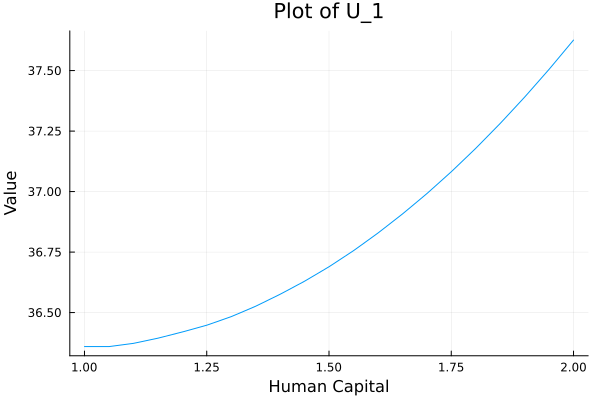

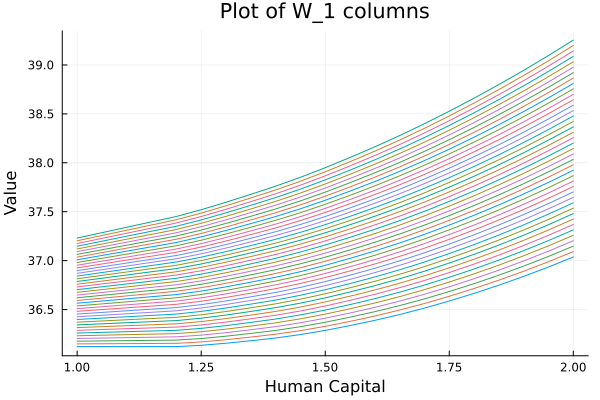

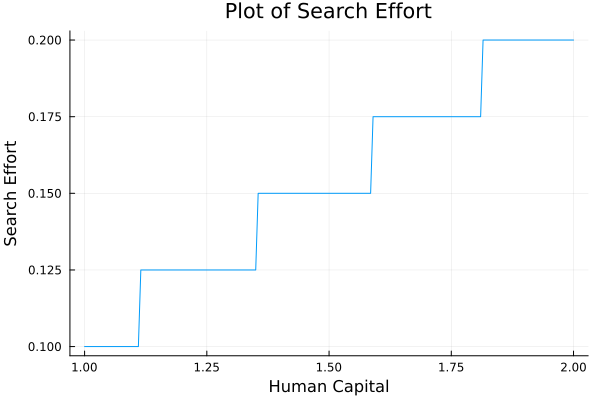

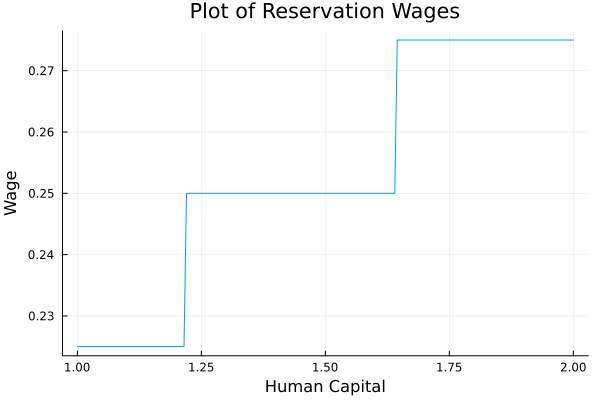

([36.12133232068262 36.14906070265273 … 37.202739217517085 37.2304675994872; 36.12133232068262 36.149199268085724 … 37.20814326940375 37.236010216806854; … ; 37.02711222497199 37.08239983273553 … 39.18332892775024 39.238616535513785; 37.03736230027821 37.09278847347474 … 39.19898305494313 39.254409228139664], [36.359460251507805; 36.359460251507805; … ; 37.61405078397008; 37.62616478864133;;], [0.1; 0.1; … ; 0.2; 0.2;;], [0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225  …  0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275])

In [20]:
@time begin
    W_out, U_out, match_probs, res_wages = Bellman_final(Bounds, Losses, Sizes, Params, 1e-3, 1000, 0.0016753524541854858)
end

## Make some small changes to the functions (reuse the value functions from the old tau as the initial guess for the new tau; also tighten the convergence criteria)

In [15]:
function NEW_Bellman(B, L, S, P, tolerance, max_iterations, tau, U_0, W_0)

    # U_0, W_0 = initial_value_functions(S)

    U_1, W_1 = similar(U_0), similar(W_0)

    search_intensity = similar(U_0)

    store_U_values = zeros(S[2], S[3])

    hc_grid = human_capital_grid(S,B)

    s_grid = search_grid(S,B)

    w_grid, w_probs = wage_grid(S,B)

    cost = cost_of_search(S,B)

    contact_probs = contact_probability(S,B)

    reservation_wages = Float64[]

    error = tolerance + 1

    iter = 1

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid)

    b = P[4]

    unemployment_loss, job_loss = L[1], L[2]

    hc_tomorrow_unemp = 0

    #display("----- Iterating... -----")

    while error > tolerance

        for i in 1:S[1]

            if i <= 11

                hc_tomorrow_unemp = min_hc

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            else

                hc_tomorrow_unemp = hc_grid[i-10]

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            end

            for i in 1:S[1]

                if i <= 31

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[1,1]))

                    end

                else 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i,j]) + ((P[5] * (1 - P[4]) * U_1[i-30,1]))

                    end

                end

            end

        end

        error_unemp = maximum(abs.(U_1 - U_0))

        error_emp = maximum(abs.(W_1 - W_0))

        error = max(error_unemp, error_emp)

        if iter % 25 == 0

            println("Iteration: ", iter, " Error: ", error)

        end

        U_0, W_0 = copy(U_1), copy(W_1)

        iter += 1
    
    end

    for i in 1:S[1]

        index = findfirst(x -> x >= U_1[i,1], W_1[i,:])
        
        if index !== nothing

            push!(reservation_wages, w_grid[index]) # Append the reservation wage

        else

            push!(reservation_wages, w_grid[S[3]])  # Append the max value of the wage grid (if the reservation wage would be outside the upper bound on the grid)

        end

    end

    #display("---- Bellman has been solved... ----")

    #display(plot(U_1, title = "Plot of U_1", xlabel = "Human Capital Index", ylabel = "Value", legend = false))

    #plot(W_1[:,1], title = "Plot of W_1 columns", xlabel = "Human Capital Index", ylabel = "Value", legend = false)

    #for j in 2:size(W_1, 2)
    #    plot!(W_1[:,j])
    #end

    #display(plot!())

    #display(plot(search_intensity, title = "Plot of Search Costs", xlabel = "Human Capital Index", ylabel = "Search Costs", legend = false))

    #display(plot(reservation_wages, title = "Plot of Reservation Wages", xlabel = "Human Capital Index", ylabel = "Wage", legend = false))

    return W_1, U_1, search_intensity, reservation_wages

end

NEW_Bellman (generic function with 1 method)

In [16]:
function NEW_sim( D, S, B, L, P, tol, max_iterations, tau, U_0, W_0)

    W_out, U_out, search_int, res_wages = NEW_Bellman(B, L, S, P, tol, max_iterations, tau, U_0, W_0) # solve for the value and policy functions

    hc_draws, sacked_prob, w_offers, death_prob, match_prob = draw_matrices(D, S, B, L, P) # draw the random matrices

    employment_sim, wage_sim, hc_sim = initialise_matrices(D, S, B, L, P) # initialise the matrices where will store the simulation results

    hc_grid = human_capital_grid(S,B) # human capital grid

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid) # human capital bounds

    unemployment_loss, job_loss = L[1], L[2] # human capital losses

    N, T = D[1], (D[2]-1) # N = number of workers, T = number of periods

    for n in 1:N

        for t in 1:T 

            if death_prob[n,t] > P[1] # survive

                if employment_sim[n,t] == 1 # employed

                    if t == 1

                        hc_index = findfirst(isequal(hc_draws[n,1]), hc_grid) # find the index of current human capital in the initial grid (first period only)

                    else

                        hc_index = findfirst(isequal(hc_sim[n,t]), hc_grid) # find the index of current human capital in the grid

                    end

                    if sacked_prob[n,t] <= P[3] # job loss

                        employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                        wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                        if hc_index <= 31
                                    
                            hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                        else

                            hc_sim[n,t+1] = hc_grid[hc_index - job_loss] ## unemployment human capital loss

                        end

                    else # keep job

                        employment_sim[n,t+1] = 1 ## they'll be employed tomorrow

                        wage_sim[n,t+1] = wage_sim[n,t] ## the wage they'll be earning tomorrow

                        if hc_index <= 200
                                    
                            hc_sim[n,t+1] = hc_grid[hc_index+1] ## accumulate human capital until they reach the maximum

                        else

                            hc_sim[n,t+1] = max_hc ## human capital is bounded above

                        end

                    end

                else # unemployed

                    if t == 1

                        hc_index = findfirst(isequal(hc_draws[n,1]), hc_grid) # find the index of current human capital in the initial grid (first period only)

                    else

                        hc_index = findfirst(isequal(hc_sim[n,t]), hc_grid) # find the index of current human capital in the grid

                    end

                    if match_prob[n,t] < search_int[hc_index] # match

                        if w_offers[n,t] > res_wages[hc_index] ## if they'd accept the wage offer

                            wage_sim[n,t+1] = w_offers[n,t] ## they'll be earning the wage tomorrow

                            employment_sim[n,t+1] = 1 ## they'll be employed tomorrow

                            if hc_index <= 21
                                    
                                hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                            else

                                hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                            end

                        else ## if they wouldn't accept the wage offer

                            wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                            employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                            if hc_index <= 11
                                    
                                hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                            else

                                hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                            end

                        end

                    else # stay unemployed

                        wage_sim[n,t+1] = 0 ## they won't be earning anything tomorrow (fill in benefits later)

                        employment_sim[n,t+1] = 0 ## they'll be unemployed tomorrow

                        if hc_index <= 11
                                    
                            hc_sim[n,t+1] = min_hc ## lose human capital until they reach the minimum

                        else

                            hc_sim[n,t+1] = hc_grid[hc_index - unemployment_loss] ## unemployment human capital loss

                        end

                    end

                end

            else # die

                hc_sim[n,t+1] = hc_draws[n,t] ## replaced by a newborn

                employment_sim[n,t+1] = 0 ## who will start unemployed

                wage_sim[n,t+1] = 0 ## and won't be earning anything tomorrow (fill in benefits later)

            end

        end
    
    end

    return employment_sim, wage_sim, hc_sim, U_out, W_out

end

NEW_sim (generic function with 1 method)

In [17]:
function NEW_find_tax_rate(D, S, B, L, P, Bellman_tolerance, maximum_iterations)
    # Initialise the value functions
    U = zeros(S[1], 1)
    W = zeros(S[1], S[2])

    # Params
    number_of_workers = D[1]
    
    # Initialise the tax rate bounds
    lower_bound = 0.0
    upper_bound = 1.0

    # Define the number of columns to extract
    num_columns = 100

    government_spending = ones(D[1], 100)
    # Initialise the unemployment rate
    unemployment_rate = 5.0

    while abs(sum(government_spending)) > 0.01
        # update the guess
        guess_tau = (lower_bound + upper_bound) / 2
        # simulate the economy with the new guess
        employment_sim, wage_sim, hc_sim, U, W = NEW_sim( D, S, B, L, P, Bellman_tolerance, maximum_iterations, guess_tau, U, W) # Simulate the economy

        # Create new matrices with the last 100 columns
        employment_sim_last_100 = employment_sim[:, end-num_columns+1:end]

        wage_sim_last_100 = wage_sim[:, end-num_columns+1:end]

        hc_sim_last_100 = hc_sim[:, end-num_columns+1:end]

        # Fill in wage_sim with (1-guess_tau)*b where employment_sim is zero
        wage_sim_last_100[employment_sim_last_100 .== 0] .= (1 - guess_tau) * P[3]
        # Fill in wage_sim with (1-guess_tau)*wage_sim*hc_sim where employment_sim is one
        wage_sim_last_100[employment_sim_last_100 .== 1] .= ((1 - guess_tau) .* wage_sim_last_100[employment_sim_last_100 .== 1]) .* hc_sim_last_100[employment_sim_last_100 .== 1]
        # Fill in government_spending with -(1-guess_tau)*b where employment_sim is zero
        government_spending[employment_sim_last_100 .== 0] .= -(1-guess_tau) * P[3]
        # Fill in government_spending with (guess_tau*wage_sim*hc_sim) where employment_sim is one
        government_spending[employment_sim_last_100 .== 1] .= ((guess_tau .* wage_sim_last_100[employment_sim_last_100 .== 1]) .* hc_sim_last_100[employment_sim_last_100 .== 1])
        #Find the unemployment rate
        unemployment_rate = sum(employment_sim_last_100 .== 0) / (number_of_workers) # get rid of num_columns so that it is a percentage      

        # Check if the market clears
        if sum(government_spending) < 0

            lower_bound = guess_tau

            upper_bound = upper_bound

        else

            lower_bound = lower_bound

            upper_bound = guess_tau

        end
        println("---------------------")
        println("Lower bound: ", lower_bound, " Upper bound: ", upper_bound)
        println("Government spending: ", sum(government_spending))
        println("Unemployment rate: ", unemployment_rate)
        println("---------------------")
    end
    # once convergence is reached, return the tax rate and the unemployment rate
    tax_rate = (lower_bound + upper_bound) / 2

    return tax_rate*100, unemployment_rate
end

NEW_find_tax_rate (generic function with 1 method)

In [30]:
@time begin
tax_rate, unemployment_rate = NEW_find_tax_rate(Draw, Sizes, Bounds, Losses, Params, 1e-5, 2000)
end

Iteration: 25 Error: 0.10910697785816836
Iteration: 50 Error: 0.0886352178392471
Iteration: 75 Error: 0.07238027064038377
Iteration: 100 Error: 0.05915665462775088
Iteration: 125 Error: 0.048370540358066094
Iteration: 150 Error: 0.03957447241278622
Iteration: 175 Error: 0.03237886570434334
Iteration: 200 Error: 0.026518293908809554
Iteration: 225 Error: 0.02171854583593813
Iteration: 250 Error: 0.017786864612473252
Iteration: 275 Error: 0.014566744043627011
Iteration: 300 Error: 0.011939011847653447
Iteration: 325 Error: 0.009788881231608926
Iteration: 350 Error: 0.008025973756396354
Iteration: 375 Error: 0.0065808953559862715
Iteration: 400 Error: 0.005395723185422696
Iteration: 425 Error: 0.004424142182974933
Iteration: 450 Error: 0.0036273858283699667
Iteration: 475 Error: 0.002974185494871051
Iteration: 500 Error: 0.0024385559660728973
Iteration: 525 Error: 0.001999389483245295
Iteration: 550 Error: 0.001639337459362622
Iteration: 575 Error: 0.0013441045115847317
Iteration: 600 Err

(0.16768351197242737, 19.9305)